# Optimization via Stochastic Gradient Descent

In [1]:
import sys; sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from tqdm import tqdm
from utils.optimization import gd
from utils.PCAClassifier import PCAClassifier
from utils.SVDClassifier import SVDClassifier

np.random.seed(42)

In [2]:
def sgd(loss, grad_loss, w0, data, batch_size, n_epochs, lr, random_seed=42):
    X, y = data
    data_size = X.shape[1]
    curr_w = w0
    history_w = [w0]
    history_loss = [loss(w0, X, y)]
    history_grad = [grad_loss(w0, X, y)]
    history_err = [np.linalg.norm(history_grad[-1], 2)]

    for _ in range(n_epochs):
        idxs = np.arange(0, data_size)
        np.random.default_rng(random_seed).shuffle(idxs)

        for i in range(math.ceil(data_size / batch_size)):
            batch_idxs = idxs[i*batch_size : (i+1)*batch_size]
            batch_X = X[:, batch_idxs]
            batch_y = y[batch_idxs]

            curr_w = curr_w - lr*grad_loss(curr_w, batch_X, batch_y)

        history_w.append(curr_w)
        history_loss.append(loss(curr_w, X, y))
        history_grad.append(grad_loss(curr_w, X, y))
        history_err.append( np.linalg.norm(history_grad[-1], 2) )

    return history_w, history_loss, history_grad, history_err

## Data preparation

In [3]:
def train_test_split(X, Y, train_size, random_seed=42):
    rng = np.random.default_rng(random_seed)

    idxs = np.arange(0, X.shape[1])
    rng.shuffle(idxs)
    X_train = X[:, idxs[:train_size]]
    Y_train = Y[idxs[:train_size]]
    X_test = X[:, idxs[train_size:]]
    Y_test = Y[idxs[train_size:]]

    return X_train, Y_train, X_test, Y_test


def filterDigits(X, Y, digits):
    select_mask = np.full(Y.shape, False)
    for d in digits:
        select_mask |= (Y == d)
    return X[:, select_mask], Y[select_mask]

def onehot(Y_digits):
    digits = np.unique(Y_digits).tolist()
    return np.array([ [0]*((digits.index(d))) + [1] + [0]*((len(digits) - digits.index(d)-1)) for d in Y_digits ])

def addColumn(A):
    out = np.ones((A.shape[0]+1, A.shape[1]))
    out[1:, :] = A
    return out

def createDataset(X, Y, digits, classification_type="binary", train_ratio=0.75):
    X = addColumn(X)
    X, Y = filterDigits(X, Y, digits)

    if classification_type == "binary":
        Y[Y == digits[0]] = 0
        Y[Y == digits[1]] = 1
    elif classification_type == "multi":
        Y = onehot(Y)
    else: raise Exception("Invalid type")

    return train_test_split(X, Y, int(train_ratio*X.shape[1]))

In [4]:
data = pd.read_csv("../homework2/data/data.csv")
data = data.to_numpy()

full_X = data[:, 1:].T
full_Y = data[:, 0].T
print(full_X.shape, full_Y.shape)

(784, 42000) (42000,)


## Binary classification

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def f(w, x):
    return sigmoid(x.T @ w)


def mse(fn, w, X, y):
    return (1/2) * np.linalg.norm(fn(w, X) - y, 2)**2

def mse_grad(fn, w, X, y):
    N = X.shape[1]
    fn_X = fn(w, X)
    return ( X @ (fn_X * (1-fn_X) * (fn_X - y)) )


def loss(w, X, Y):
    N = X.shape[1]
    return (1/N) * mse(f, w, X, Y)

def grad_loss(w, X, Y):
    N = X.shape[1]
    return (1/N) * mse_grad(f, w, X, Y)

In [6]:
def evaluate(w, X_test, Y_test, threshold=0.5):
    correct = 0
    N = X_test.shape[1]

    for i in range(N):
        pred_prob = f(w, X_test[:, i])
        
        if pred_prob >= threshold:
            pred = 1
        else:
            pred = 0
            
        if pred == Y_test[i]:
            correct += 1

    return correct, correct / N

In [7]:
digits = [8, 9]
X_train, Y_train, X_test, Y_test = createDataset(full_X, full_Y, digits, classification_type="binary")
print(f"Train set -- {(Y_train == 0).sum()} class 1 ({digits[0]}) | {(Y_train == 1).sum()} class 2 ({digits[1]})")
print(f" Test set -- {(Y_test == 0).sum()} class 1 ({digits[0]}) | {(Y_test == 1).sum()} class 2 ({digits[1]})")

Train set -- 3039 class 1 (8) | 3149 class 2 (9)
 Test set -- 1024 class 1 (8) | 1039 class 2 (9)


/tmp/ipykernel_4842/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Accuracy: 0.9796412990790111


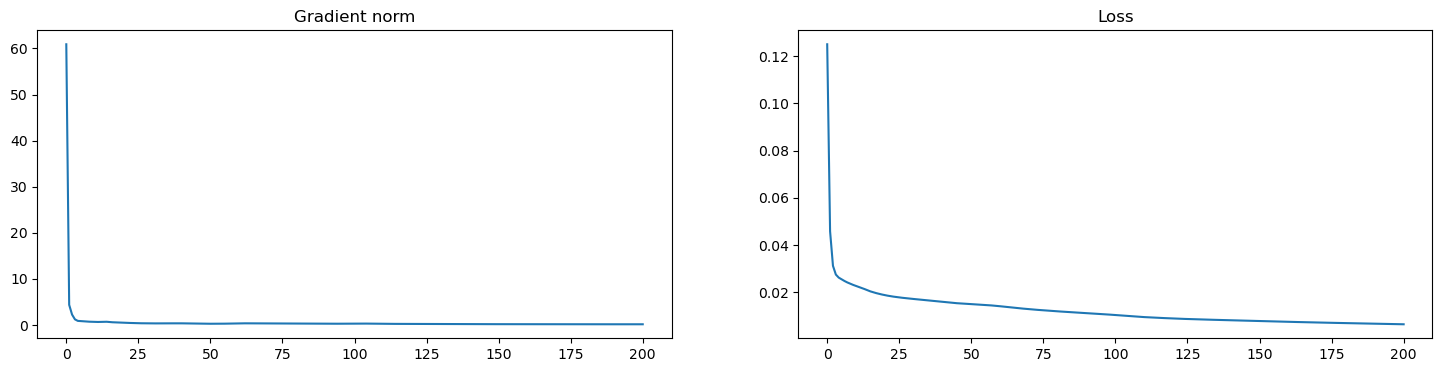

In [8]:
history_w, curr_k, history_loss, history_grad, history_err = gd(loss, grad_loss, np.zeros(X_train.shape[0]), (X_train, Y_train), 200, 1e-6, 1e-6)

correct, accuracy = evaluate(history_w[-1], X_test, Y_test)
print(f"Accuracy: {accuracy}")

plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")

plt.subplot(1, 2, 2)
plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()

Accuracy: 0.9859428017450315


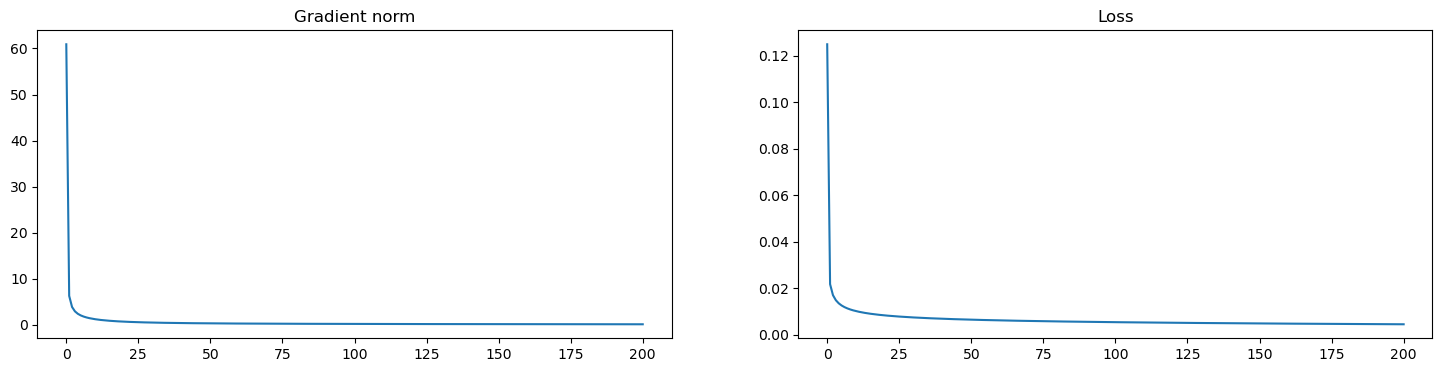

In [9]:
history_w, history_loss, history_grad, history_err = sgd(loss, grad_loss, np.zeros(X_train.shape[0]), (X_train, Y_train), batch_size=200, n_epochs=200, lr=1e-5)

correct, accuracy = evaluate(history_w[-1], X_test, Y_test)
print(f"Accuracy: {accuracy}")

plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")

plt.subplot(1, 2, 2)
plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()

In [10]:
class BinaryLogisticRegression:
    def __init__(self):
        self.w = None

    def fit(self, X_train, Y_train, algorithm="sgd", w0=None, batch_size=200, epochs=200, lr=1e-5, tol_loss=1e-6, tol_w=1e-6):
        if algorithm == "sgd":
            history_w, history_loss, history_grad, history_err = sgd(
                loss, grad_loss, 
                w0 if w0 is not None else np.zeros(X_train.shape[0]), 
                (X_train, Y_train), 
                batch_size, epochs, lr
            )
        else:
            history_w, curr_k, history_loss, history_grad, history_err = gd(
                loss, grad_loss, 
                w0 if w0 is not None else np.zeros(X_train.shape[0]), 
                (X_train, Y_train), epochs, tol_loss, tol_w
            )
            
        self.w = history_w[-1]
        return self

    def predict(self, X, threshold=0.5):
        if X.ndim == 1:
            return 1 if f(self.w, X) >= threshold else 0
        else:
            out = []

            for i in range(X.shape[1]):
                out.append(1 if f(self.w, X[:, i]) >= threshold else 0)
            return np.array(out)        

In [11]:
def binaryDigitEvaluation(digit1, digit2):
    X_train, Y_train, X_test, Y_test = createDataset(full_X, full_Y, [digit1, digit2])

    model_sgd = BinaryLogisticRegression()
    model_gd = BinaryLogisticRegression()
    model_sgd.fit(X_train, Y_train, algorithm="sgd")
    model_gd.fit(X_train, Y_train, algorithm="gd")

    accuracy_sgd = np.sum(model_sgd.predict(X_test) == Y_test) / Y_test.shape[0]
    accuracy_gd = np.sum(model_gd.predict(X_test) == Y_test) / Y_test.shape[0]
    
    print(f"------ Classifying {digit1} {digit2} ------")
    print(f"||w_sgd - w_gd||_2 = {np.linalg.norm(model_sgd.w - model_gd.w)}")
    print(f"SGD acc. = {accuracy_sgd} | GD acc. {accuracy_gd}")

binaryDigitEvaluation(0, 1)
binaryDigitEvaluation(8, 9)

/tmp/ipykernel_4842/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


------ Classifying 0 1 ------
||w_sgd - w_gd||_2 = 0.10612050107776898
SGD acc. = 0.9986388384754991 | GD acc. 0.9950090744101633
------ Classifying 8 9 ------
||w_sgd - w_gd||_2 = 0.03983523738186209
SGD acc. = 0.9859428017450315 | GD acc. 0.9796412990790111


In [12]:
def trainModels(train_ratio):
    models_sgd = {}
    models_gd = {}

    for i in range(0, 10):
        for j in range(i, 10):
            X_train, Y_train, X_test, Y_test = createDataset(full_X, full_Y, [i, j], classification_type="binary", train_ratio=train_ratio)
            
            model_sgd = BinaryLogisticRegression()
            model_sgd.fit(X_train, Y_train, "sgd", epochs=200)
            models_sgd[(i,j)] = models_sgd[(j, i)] = (model_sgd, X_test, Y_test)

            model_gd = BinaryLogisticRegression()
            model_gd.fit(X_train, Y_train, "gd", epochs=200)
            models_gd[(i,j)] = models_gd[(j, i)] = (model_gd, X_test, Y_test)

    return models_sgd, models_gd


def accuracyHeatMapData(models):
    accuracies = np.zeros((10, 10))

    for i in range(0, 10):
        for j in range(i, 10):
            if i == j: 
                accuracies[i, j] = 1
                continue

            model, X_test, Y_test = models[(i, j)]
            accuracies[i, j] = accuracies[j, i] = np.sum(model.predict(X_test) == Y_test) / Y_test.shape[0]

    return accuracies


def paramsDiffHeatMapData(models_sgd, models_gd):
    differences = np.zeros((10, 10))

    for i in range(0, 10):
        for j in range(i, 10):
            if i == j: 
                differences[i, j] = None
                continue
            model_sgd, _, _ = models_sgd[(i, j)]
            model_gd, _, _ = models_gd[(i, j)]
            differences[i, j] = differences[j, i] = np.linalg.norm(model_sgd.w - model_gd.w, 2)

    return differences

0it [00:00, ?it/s]

/tmp/ipykernel_4842/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


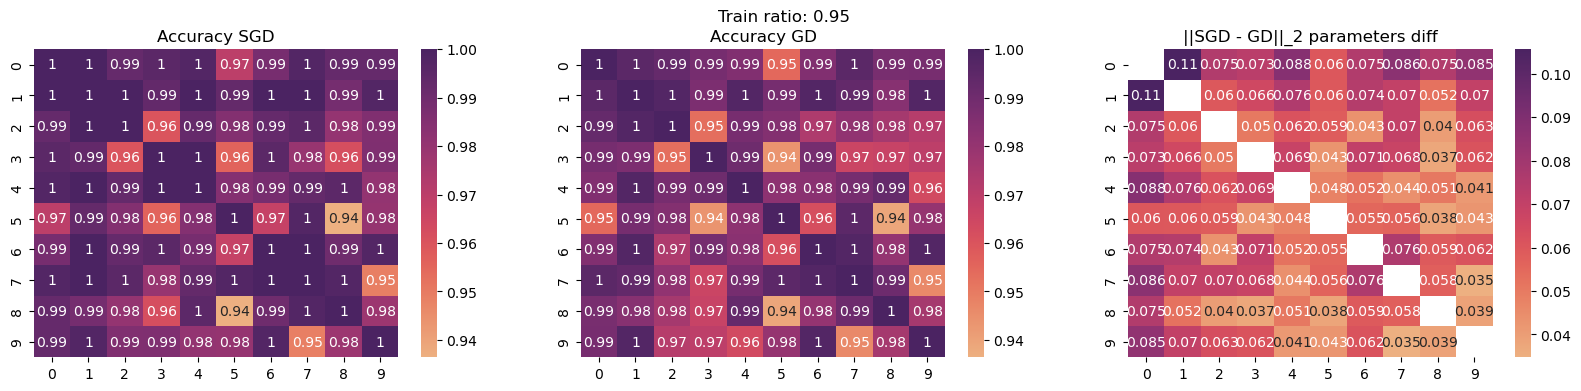

1it [03:43, 223.82s/it]/tmp/ipykernel_4842/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


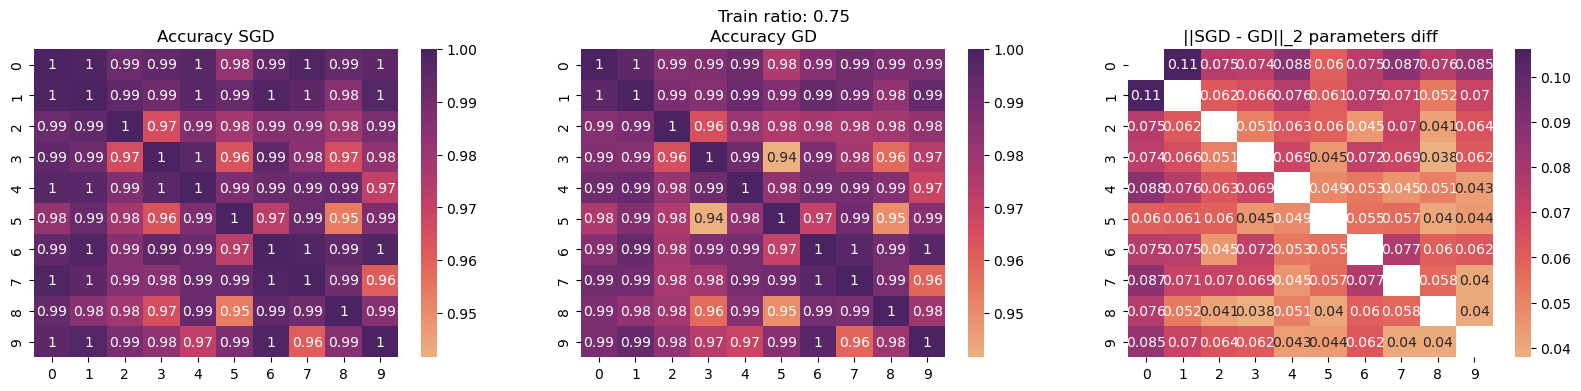

2it [06:36, 194.03s/it]/tmp/ipykernel_4842/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


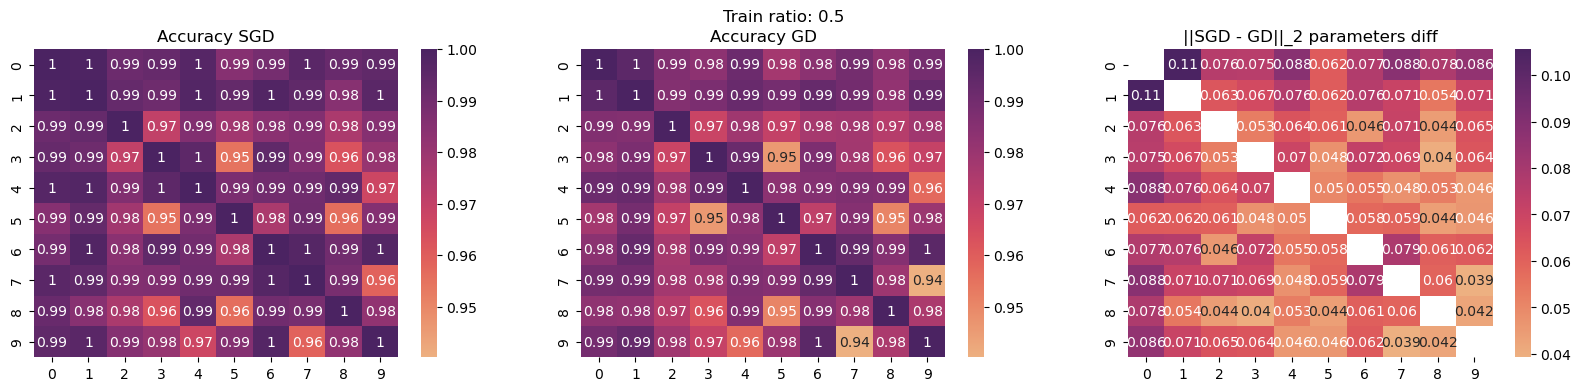

3it [08:26, 155.38s/it]/tmp/ipykernel_4842/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


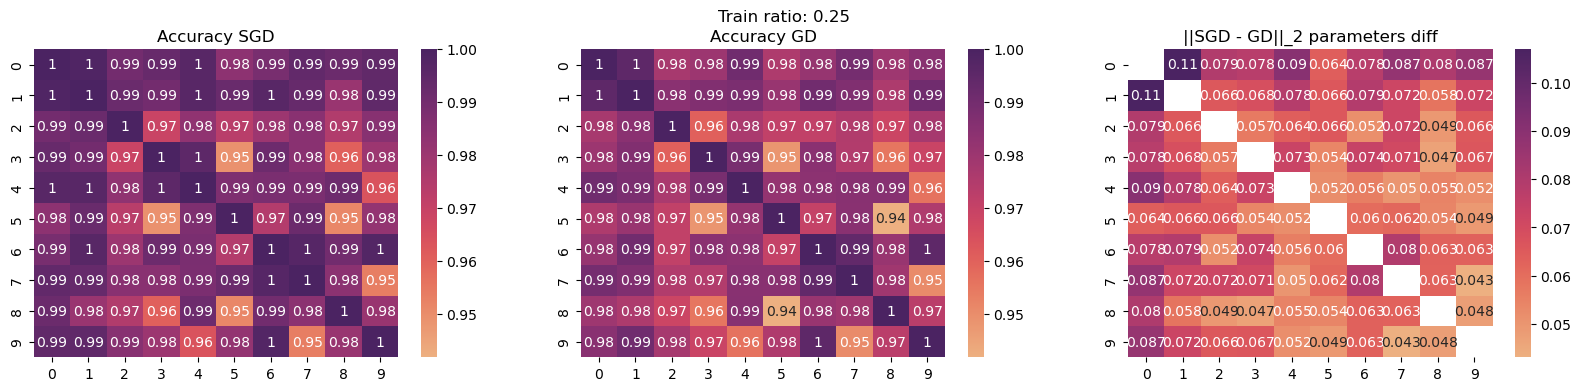

4it [09:08, 137.22s/it]


In [13]:
to_test_ratio = [0.95, 0.75, 0.5, 0.25]

for i, ratio in tqdm(enumerate(to_test_ratio)):
    models_sgd, models_gd = trainModels(ratio)

    accuracies_sgd = accuracyHeatMapData(models_sgd)
    accuracies_gd = accuracyHeatMapData(models_gd)
    param_diffs = paramsDiffHeatMapData(models_sgd, models_gd)


    plt.figure(figsize=(20, 4))
    plt.suptitle(f"Train ratio: {ratio}")
    
    plt.subplot(1, 3, 1)
    plt.title(f"Accuracy SGD")
    sns.heatmap(accuracies_sgd, annot=True,  
        cmap=sns.color_palette("flare", as_cmap=True), 
        vmin=min(np.min(accuracies_sgd), np.min(accuracies_gd)), vmax=max(np.max(accuracies_sgd), np.max(accuracies_gd))
    )

    plt.subplot(1, 3, 2)
    plt.title(f"Accuracy GD")
    sns.heatmap(accuracies_gd, annot=True,  
        cmap=sns.color_palette("flare", as_cmap=True), 
        vmin=min(np.min(accuracies_sgd), np.min(accuracies_gd)), vmax=max(np.max(accuracies_sgd), np.max(accuracies_gd))
    )
    
    plt.subplot(1, 3, 3)
    plt.title(f"||SGD - GD||_2 parameters diff")
    sns.heatmap(param_diffs, annot=True,  cmap=sns.color_palette("flare", as_cmap=True))

    plt.show()

## Multi-class classification

\begin{equation*}
    w: N \times 3
\end{equation*}

\begin{split}
    MSE&: (N \times 3) \rightarrow 1 \\
    \nabla MSE&: (N \times 3) \rightarrow (N \times 3)
\end{split}

\begin{split}
    \sigma&: 3 \rightarrow 3 \\
    \nabla\sigma&: 3 \rightarrow (3 \times 3)
\end{split}

\begin{split}
    f&: (N \times 3) \rightarrow 3 \\
    \nabla f&: (N \times 3) \rightarrow (3 \times N \times 3)
\end{split}

\begin{equation*}
    \sigma_i(z) = \frac{e^{z_i}}{\sum_{j=1}^N e^{z_j}} 
    \hspace{2cm} 
    \frac{\partial \sigma(z_i)}{\partial z_j} = \sigma(z_i) (\delta_{ij} - \sigma(z_j)) 
    \hspace{0.5cm}
    \delta_{ij} = \begin{cases} 1 & \text{if } i=j \\ 0 & \text{if } i \neq j \end{cases}
\end{equation*}


In [14]:
def softmax(z):
    # exp_z = np.exp(z - np.max(z))
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z)

def softmax_grad(z):
    # grad_matr = []
    # for i in range(z.shape[0]):
    #     grad_row = []
    #     for j in range(z.shape[0]):
    #         delta = 1 if i == j else 0
    #         grad_row.append( softmax(z)[i] * (delta - softmax(z)[j]) )
    #     grad_matr.append(grad_row)
    
    # return np.array(grad_matr)

    s = softmax(z)
    return np.diag(s) - np.outer(s, s)


def f_multi(w, x):
    return softmax(x.T @ w)

def f_multi_grad(w, x):
    def __grad(a):
        grad = softmax_grad(a.T @ w)
        # return np.array([ np.outer(a.T, grad[i, :]) for i in range(grad.shape[0]) ])
        return np.einsum('ij,k->ikj', grad, a)
    
    if x.ndim == 1: return __grad(x)
    # return np.array([ __grad(x[:, i]) for i in range(x.shape[1]) ])
    return np.apply_along_axis(__grad, axis=0, arr=x).T
 

def mse(f, w, D):
    X, y = D
    return (1/2) * (np.linalg.norm(f(w, X) - y, 2)**2)

def mse_grad(f, grad_f, w, D):
    X, y = D
    N = X.shape[1]
    grad = grad_f(w, X)
    f_x = f(w, X)

    # out = [ grad[i] @ (f_x[i] - y[i]) for i in range(N) ]
    out = np.einsum('Bijk,Bk->Bij', grad, (f_x - y))

    return np.mean(out, axis=0).T


def loss_multi(w, X, Y):
    N = X.shape[1]
    return (1/N) * mse(f_multi, w, (X, Y))

def grad_loss_multi(w, X, Y):
    N = X.shape[1]
    return (1/N) * mse_grad(f_multi, f_multi_grad, w, (X, Y))

In [15]:
def evaluateMulti(w, X_test, Y_test):
    correct = 0
    N = X_test.shape[1]

    for i in range(N):
        pred_probs = f_multi(w, X_test[:, i])
        
        if np.argmax(pred_probs) == np.argmax(Y_test[i]):
            correct += 1

    return correct, correct / N

In [16]:
digits = [1, 8, 9]
X_train, Y_train, X, Y = createDataset(full_X, full_Y, digits, classification_type="multi")

for digit, train_size, test_size in zip([d for d in digits], np.sum(Y_train, axis=0), np.sum(Y, axis=0)):
    print(f"{digit} | {train_size} train -- {test_size} test")

1 | 3472 train -- 1212 test
8 | 3079 train -- 984 test
9 | 3150 train -- 1038 test


Accuracy: 0.9400123685837971


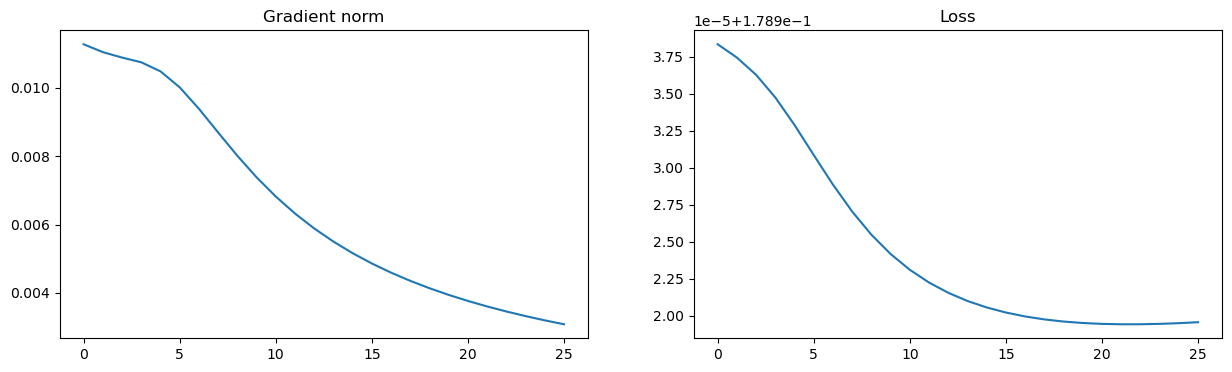

In [17]:
history_w, history_loss, history_grad, history_err = sgd(
    loss_multi, grad_loss_multi, np.zeros((X_train.shape[0], len(digits))), (X_train, Y_train), batch_size=200, n_epochs=25, lr=1e-5
)

print(f"Accuracy: {evaluateMulti(history_w[-1], X, Y)[1]}")

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")
plt.subplot(1, 2, 2)
plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()


Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 5 was incorrect on entry to DLASCL.
Accuracy: 0.9214594928880643


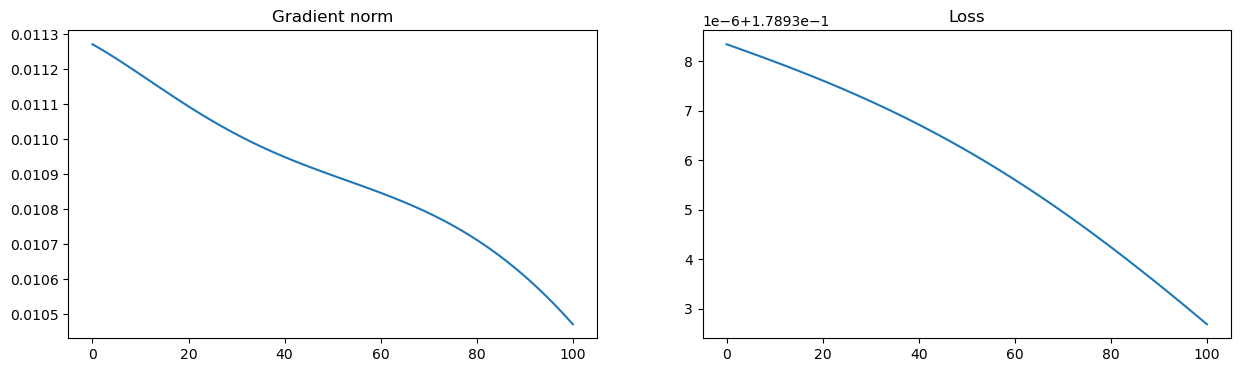

In [18]:
history_w, curr_k, history_loss, history_grad, history_err = gd(
    loss_multi, grad_loss_multi, np.zeros((X_train.shape[0], len(digits))), (X_train, Y_train), 100, 1e-6, 1e-6
)

print(f"Accuracy: {evaluateMulti(history_w[-1], X, Y)[1]}")

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")
plt.subplot(1, 2, 2)
plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()

### SVD vs PCA vs Logistic regression

In [19]:
class MNISTLogisticClassifier:
    def __init__(self):
        self.w = None
        self.digits = []

    def fit(self, X_train, Y_train, epochs=25, batch_size=200, lr=1e-5):
        self.digits = np.unique(Y_train).tolist()
        history_w, history_loss, history_grad, history_err = sgd(
            loss = loss_multi, grad_loss = grad_loss_multi, 
            w0 = np.zeros((X_train.shape[0], len(self.digits))), 
            data = (X_train, onehot(Y_train)), 
            n_epochs = epochs, 
            batch_size = batch_size, 
            lr = lr
        )
        self.w = history_w[-1]
        return self

    def predict(self, new_digit):
        preds = f_multi(self.w, new_digit)
        return self.digits[np.argmax(preds)]

In [20]:
def accuracy(classifier, X, Y):
    correct = 0
    for i in range(X.shape[1]):
        pred = classifier.predict(X[:, i])
        if pred == Y[i]: correct += 1
    return correct / X.shape[1]

def buildDataset(X, Y, digits):
    X, Y = filterDigits(X, Y, digits)
    return train_test_split(X, Y, int(0.75*X.shape[1]))


X_train, Y_train, X_test, Y_test = buildDataset(full_X, full_Y, [0, 1, 8])

pca_classifier = PCAClassifier()
pca_classifier.fit(X_train, Y_train, k=15)
print(f"PCA                 accuracy: {accuracy(pca_classifier, X_test, Y_test)}")

svd_classifier = SVDClassifier()
svd_classifier.fit(X_train, Y_train)
print(f"SVD                 accuracy: {accuracy(svd_classifier, X_test, Y_test)}")

logistic_classifier = MNISTLogisticClassifier()
logistic_classifier.fit(X_train, Y_train, batch_size=200, epochs=25)
print(f"Logistic regression accuracy: {accuracy(logistic_classifier, X_test, Y_test)}")

PCA                 accuracy: 0.9406832298136646
SVD                 accuracy: 0.6751552795031056
Logistic regression accuracy: 0.9503105590062112


In [21]:
accuracies = pd.DataFrame(columns=["Digits", "SVD accuracy", "PCA accuracy", "Logistic accuracy", "Best"])
to_eval_digits = set()

for i in range(0, 10):
    for j in range(i+1, 10):
        for k in range(j+1, 10):
            to_eval_digits.add(tuple(sorted([i, j, k])))

for digits in tqdm(to_eval_digits):
    X_train, Y_train, X_test, Y_test = buildDataset(full_X, full_Y, digits)
    
    svd_classifier = SVDClassifier().fit(X_train, Y_train)
    pca_classifier = PCAClassifier().fit(X_train, Y_train, k=15)
    logistic_classifier = MNISTLogisticClassifier().fit(X_train, Y_train, batch_size=200, epochs=25)
    
    svd_accuracy = accuracy(svd_classifier, X_test, Y_test)
    pca_accuracy = accuracy(pca_classifier, X_test, Y_test)
    logistic_accuracy = accuracy(logistic_classifier, X_test, Y_test)


    if pca_accuracy > logistic_accuracy and pca_accuracy > svd_accuracy:
        best = "PCA" 
    elif logistic_accuracy > pca_accuracy and logistic_accuracy > svd_accuracy:
        best = "Logistic"
    elif svd_accuracy > logistic_accuracy and svd_accuracy > pca_accuracy:
        best = "SVD"
    else: best = "---"

    accuracies.loc[len(accuracies)] = [digits, svd_accuracy, pca_accuracy, logistic_accuracy, best]

accuracies = accuracies.sort_values(by=["Logistic accuracy", "PCA accuracy", "SVD accuracy"], ascending=False)
display(accuracies)

100%|██████████| 120/120 [1:20:33<00:00, 40.28s/it]


,Digits,SVD accuracy,PCA accuracy,Logistic accuracy,Best
114,"(0, 1, 4)",0.784916,0.969274,0.985413,Logistic
66,"(1, 6, 9)",0.980633,0.965878,0.980326,SVD
85,"(0, 1, 7)",0.940998,0.966717,0.978517,Logistic
96,"(0, 1, 9)",0.882190,0.958782,0.976315,Logistic
56,"(1, 6, 7)",0.972172,0.955535,0.975499,Logistic
...,...,...,...,...,...
79,"(2, 3, 5)",0.604025,0.839013,0.865628,Logistic
113,"(3, 5, 7)",0.853682,0.883966,0.830730,PCA
14,"(0, 3, 5)",0.726710,0.849186,0.827362,PCA
44,"(3, 5, 8)",0.722896,0.814281,0.808713,PCA


In [23]:
pd.set_option("display.max_rows", None)
display(accuracies)

,Digits,SVD accuracy,PCA accuracy,Logistic accuracy,Best
114,"(0, 1, 4)",0.784916,0.969274,0.985413,Logistic
66,"(1, 6, 9)",0.980633,0.965878,0.980326,SVD
85,"(0, 1, 7)",0.940998,0.966717,0.978517,Logistic
96,"(0, 1, 9)",0.882190,0.958782,0.976315,Logistic
56,"(1, 6, 7)",0.972172,0.955535,0.975499,Logistic
81,"(0, 6, 9)",0.815730,0.955056,0.973034,Logistic
102,"(0, 4, 7)",0.930203,0.957805,0.972398,Logistic
4,"(4, 6, 7)",0.943546,0.958135,0.971456,Logistic
89,"(1, 4, 6)",0.958437,0.950372,0.970844,Logistic
54,"(0, 4, 6)",0.880752,0.953338,0.970512,Logistic
